In [ ]:
!pip install pandas
!pip install matplotlib

In [61]:
PROCESSORS_NUM = 10
RAM = 12
PARALLEL_CLIENTS = 100
TIME_IN_SECONDS = 280

NUM_PGPOOL = 2
NUM_POSTGRES = 2
NUM_CASSANDRA = 3
NUM_NGINX = 2
NUM_WEB_APP = 3

In [55]:
import matplotlib.pyplot as plt


In [62]:
import pandas as pd
import pathlib

def load_and_process_logs(directory_path, replacements):
    df = pd.DataFrame()
    
    for file in pathlib.Path(directory_path).iterdir():
        temp_df = pd.read_csv(file, names=['timestamp', 'type', 'endpoint', 'method', 'query', 'status', 'duration', 'operation'], parse_dates=['timestamp'])
        df = pd.concat([df, temp_df])
    
    df['duration'] = pd.to_numeric(df['duration'], errors='coerce') 
    
    df_responses = df[df['type'] == 'response'] 

    for old, new in replacements.items():
        df_responses['endpoint'] = df_responses['endpoint'].str.replace(old, new)

    df_responses['endpoint_combined'] = df_responses['endpoint'].str.split('?').str[0]

    return df_responses

def calculate_metrics(df_responses):
    total_time = (df_responses['timestamp'].max() - df_responses['timestamp'].min()).total_seconds()
    rps_combined = df_responses.groupby('endpoint_combined')['timestamp'].count() / total_time
    total_requests_per_combined_endpoint = df_responses.groupby('endpoint_combined')['timestamp'].count()
    
    return total_time, rps_combined, total_requests_per_combined_endpoint

# Delete request that exceeds time limit
def filter_rows_by_time_difference(df):
    df = df.sort_values('timestamp')
    
    time_difference = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()
    
    filtered_df = df[time_difference <= TIME_IN_SECONDS]
    
    return filtered_df


replacements = {
    'http://192.168.1.5:81/': '', 
    'http://192.168.1.5:82/': ''
}

df_responses_postgres = filter_rows_by_time_difference(load_and_process_logs("/Users/lex/Documents/Development/Projects/LoadTesterStarter/LoadTesterStarter/logs_postgres", replacements))
df_responses_cassandra = filter_rows_by_time_difference(load_and_process_logs("/Users/lex/Documents/Development/Projects/LoadTesterStarter/LoadTesterStarter/logs_cassandra", replacements))

total_time_postgres, rps_combined_postgres, total_requests_per_combined_endpoint_postgres = calculate_metrics(df_responses_postgres)
total_time_cassandra, rps_combined_cassandra, total_requests_per_combined_endpoint_cassandra = calculate_metrics(df_responses_cassandra)

/var/folders/sj/7vcp404j2636pgbsc2pb7_cw0000gn/T/ipykernel_69197/654978629.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_responses['endpoint'] = df_responses['endpoint'].str.replace(old, new)
/var/folders/sj/7vcp404j2636pgbsc2pb7_cw0000gn/T/ipykernel_69197/654978629.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_responses['endpoint_combined'] = df_responses['endpoint'].str.split('?').str[0]
/var/folders/sj/7vcp404j2636pgbsc2pb7_cw0000gn/T/ipykernel_69197/654978629.py:16: SettingWithCopyWa

In [63]:
total_time_postgres, total_time_cassandra

(279.99893, 279.99387)

In [64]:
rps_combined_postgres = rps_combined_postgres.drop('logout')

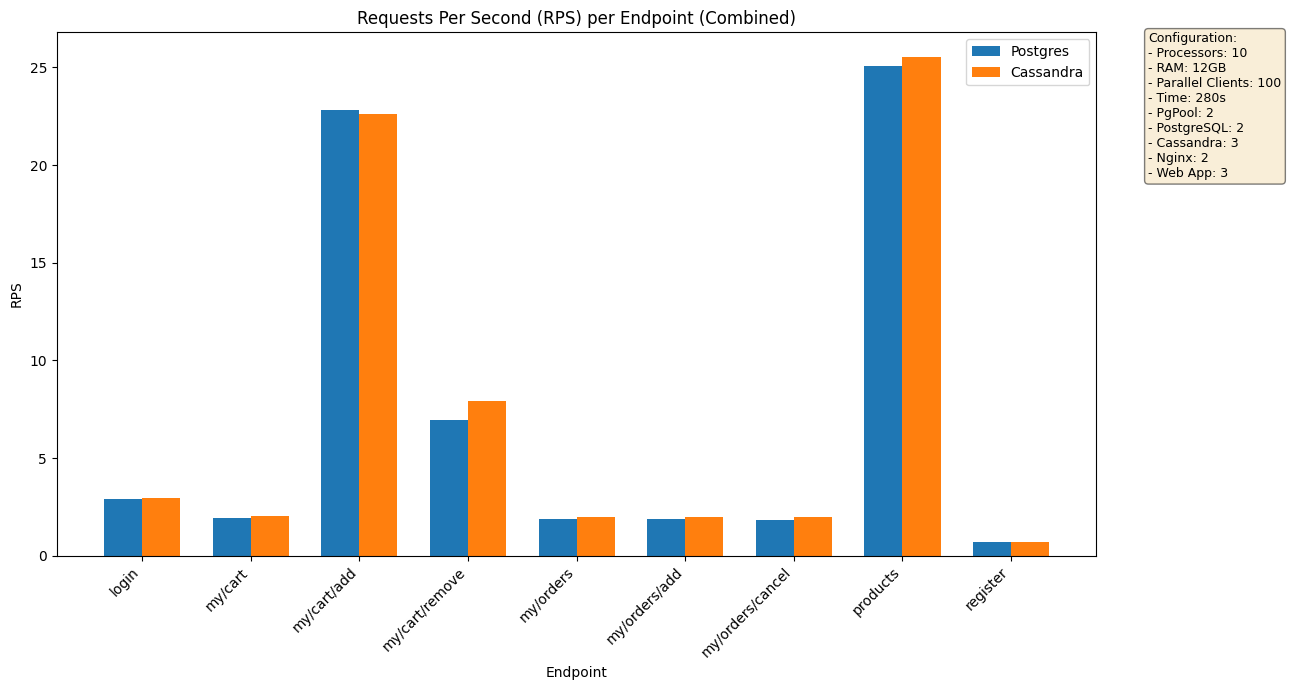

In [65]:
import numpy as np

endpoints = rps_combined_postgres.index
n = len(endpoints)
ind = np.arange(n)
width = 0.35

fig, ax = plt.subplots(figsize=(13, 7))
bars1 = ax.bar(ind - width/2, rps_combined_postgres, width, label='Postgres')
bars2 = ax.bar(ind + width/2, rps_combined_cassandra, width, label='Cassandra')

ax.set_xlabel('Endpoint')
ax.set_ylabel('RPS')
ax.set_title('Requests Per Second (RPS) per Endpoint (Combined)')
ax.set_xticks(ind)
ax.set_xticklabels(endpoints, rotation=45, ha='right')
ax.legend()

# Additional system configuration details
config_details = f"""Configuration:
- Processors: {PROCESSORS_NUM}
- RAM: {RAM}GB
- Parallel Clients: {PARALLEL_CLIENTS}
- Time: {TIME_IN_SECONDS}s
- PgPool: {NUM_PGPOOL}
- PostgreSQL: {NUM_POSTGRES}
- Cassandra: {NUM_CASSANDRA}
- Nginx: {NUM_NGINX}
- Web App: {NUM_WEB_APP}"""

# Place a text box in upper right in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.05, 1.0, config_details, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


In [67]:
total_requests_per_combined_endpoint_postgres = total_requests_per_combined_endpoint_postgres.drop('logout')

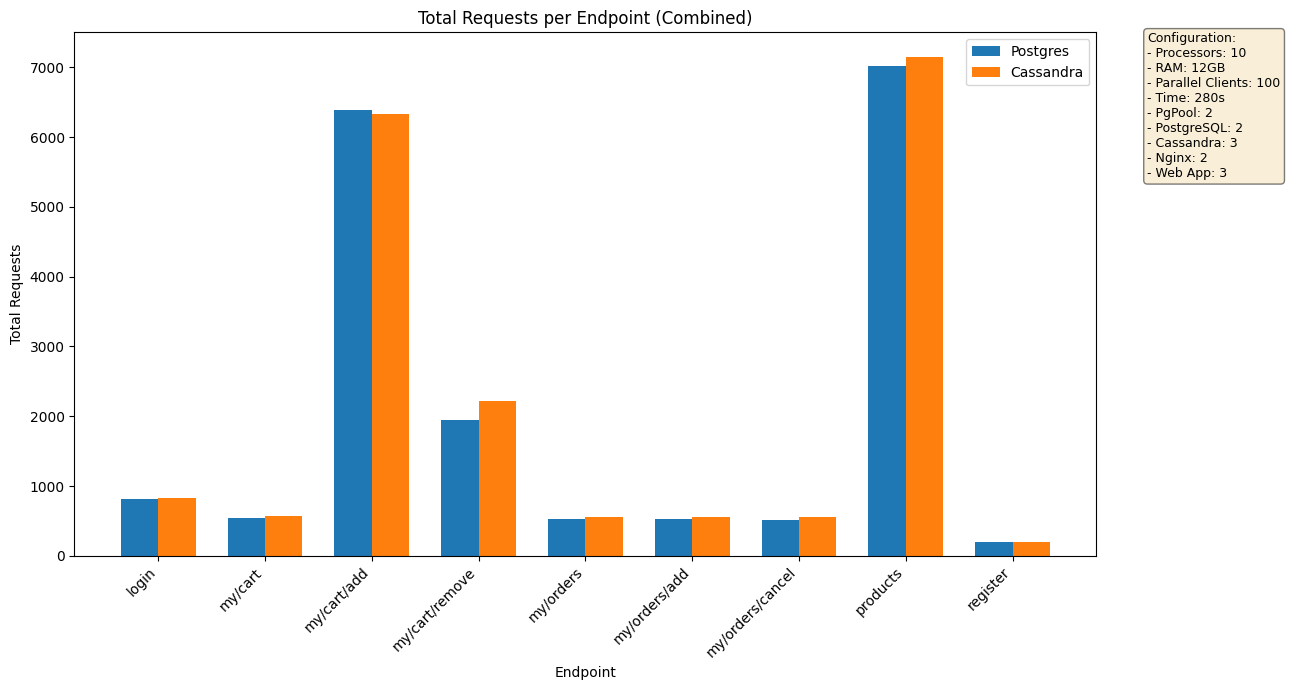

In [68]:
fig, ax = plt.subplots(figsize=(13, 7))
bars1 = ax.bar(ind - width/2, total_requests_per_combined_endpoint_postgres, width, label='Postgres')
bars2 = ax.bar(ind + width/2, total_requests_per_combined_endpoint_cassandra, width, label='Cassandra')

ax.set_xlabel('Endpoint')
ax.set_ylabel('Total Requests')
ax.set_title('Total Requests per Endpoint (Combined)')
ax.set_xticks(ind)
ax.set_xticklabels(endpoints, rotation=45, ha='right')

ax.legend()
config_details = f"""Configuration:
- Processors: {PROCESSORS_NUM}
- RAM: {RAM}GB
- Parallel Clients: {PARALLEL_CLIENTS}
- Time: {TIME_IN_SECONDS}s
- PgPool: {NUM_PGPOOL}
- PostgreSQL: {NUM_POSTGRES}
- Cassandra: {NUM_CASSANDRA}
- Nginx: {NUM_NGINX}
- Web App: {NUM_WEB_APP}"""

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(1.05, 1.0, config_details, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()